In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from helpers import *
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.metrics import silhouette_samples, silhouette_score


sns.set_style('whitegrid')
%matplotlib inline

### Clustering the cities of Attica based on their popular venues

Bellow are the datasetes that will be used for clustering 

In [2]:
attica_venues= pd.read_csv('data/venues_attica.csv')
attica_cities = pd.read_csv('data/cities_of_attica.csv')

In [3]:
attica_cities.head()

,City,Latitude,Longitude,Region,Country
0,Acharnes,38.084161,23.736865,Attica,Greece
1,Afidnes,38.205653,23.836414,Attica,Greece
2,Agia Paraskevi,40.481027,23.048260,Attica,Greece
3,Agia Varvara,35.133087,24.998196,Attica,Greece
4,Agioi Anargyroi,36.733618,24.498111,Attica,Greece


In [4]:
attica_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,labels
0,Acharnes,38.084161,23.736865,Ωδείο,38.083012,23.737051,Café,0
1,Acharnes,38.084161,23.736865,Lemonia',38.080645,23.736461,Café,0
2,Acharnes,38.084161,23.736865,Bartist Cafe/Bar,38.080025,23.736392,Cocktail Bar,0
3,Acharnes,38.084161,23.736865,Κρητικοπούλα,38.088760,23.732580,Meze Restaurant,0
4,Acharnes,38.084161,23.736865,Square,38.081541,23.735515,Café,0


### Step 1: Create the dataset that will be used for clustering 

For this step we need to create numerical features that represent the most frequent venues of the city.

In [5]:
#Venue Category column is important therefore we have to discretise the data of the column to new features 

attica_dummies = pd.get_dummies(attica_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
attica_dummies['Neighborhood'] = attica_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [attica_dummies.columns[-1]] + list(attica_dummies.columns[:-1])
attica_dummies = attica_dummies[fixed_columns]

attica_dummies.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bank,...,Tsipouro Restaurant,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Waterfall,Whisky Bar,Wine Bar,Yoga Studio
0,Acharnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Acharnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acharnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Acharnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acharnes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
attica_grouped = attica_dummies.groupby('Neighborhood').mean().reset_index()
attica_grouped.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bank,...,Tsipouro Restaurant,Turkish Restaurant,Vacation Rental,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Waterfall,Whisky Bar,Wine Bar,Yoga Studio
0,Acharnes,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.071429,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Agios Ioannis Rentis,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Agios Stefanos, Attica",0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.083333,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Aigaleo,0.018868,0.0,0.0,0.0,0.000000,0.0,0.018868,0.056604,0.000000,...,0.018868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Alimos,0.000000,0.0,0.0,0.0,0.026316,0.0,0.000000,0.078947,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0


In [7]:
#to use the data for our clustering model we need only numerical values
attica_grouped_clustering = attica_grouped.drop('Neighborhood', 1)

### Step 2: Apply Kmeans Clustering

The kmeans algorithm creates clusters of n observation into k clusters in which each observation belongs to the cluster with the nearest mean(cluster centroid).It tries to create clusters of equal variance with minimizing a criterion known as inertia. However, the algorithm requires the number of clusters to be specified beforehand. The question now is how to determine the optimal number of clusters for our dataset. In this notebook we will explore two possible ways that could provide an idea of the right choice of clusters.
- Silhouette Coefficient Score : shows the model with better defined clusters and is calculated by   b -a / max(a,b) where a is mean distance between a sample point and all aothers in the same class and b mean distance between a sample and all other points in the next nearest class.

- Elbow method : for the elbow method we have to calculate and visualize the values o inertia which is the sum of squared distances of samples to thei closest cluster center and select the value of k at the “elbow” ie the point after which the inertia start decreasing in a linear fashion

In [8]:
#first we set number of clusters that we look into 

K = range(2, 10)

for k in K:
    kmean = KMeans(n_clusters=k, random_state=10)
    cluster_labels = kmean.fit_predict(attica_grouped_clustering)
    silhouette_avg = silhouette_score(attica_grouped_clustering, cluster_labels)
    print("For k =", k, "The average silhouette_score is :", silhouette_avg)
        

For k = 2 The average silhouette_score is : 0.12375064005666292
For k = 3 The average silhouette_score is : 0.09475869733879927
For k = 4 The average silhouette_score is : 0.12565300097149243
For k = 5 The average silhouette_score is : 0.09088724117394686
For k = 6 The average silhouette_score is : 0.07977396058895962
For k = 7 The average silhouette_score is : 0.07617831758084766
For k = 8 The average silhouette_score is : 0.09809297538381674
For k = 9 The average silhouette_score is : 0.06982661256145069


2 : 4.235965674374488
3 : 3.907623739103019
4 : 3.6365980367013107
5 : 3.4049681067993536
6 : 3.253944410551383
7 : 3.098340478758931
8 : 2.893450457042065
9 : 2.8280422052738503


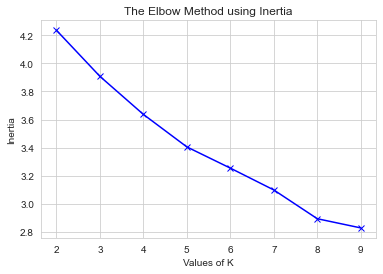

In [9]:
inertias = []

mapping2 = {}

for k in K:
        # Building and fitting the model
    kmean = KMeans(n_clusters=k, random_state=10).fit(attica_grouped_clustering)
    inertias.append(kmean.inertia_)
    mapping2[k] = kmean.inertia_


for key, val in mapping2.items():
        print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

This methods does not provide an exact choice, they are used to provide confidence on the choice of k. k= 4 according to silhouette score will be used since the elbow method showcase a linea decline for all the choices

In [10]:
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters, random_state=10).fit(attica_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 3, 3, 3, 0, 3, 1, 0, 3])

### Step 4: Combine and visualise the data

In [11]:
top10_venues =create_most_common_dataset(10,attica_grouped)

In [12]:
top10_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharnes,Café,Meze Restaurant,Bakery,Cocktail Bar,Taverna,Pizza Place,Creperie,Professional & Other Places,Pool Hall,Pool
1,Agios Ioannis Rentis,Soccer Field,Snack Place,Martial Arts School,Theater,Kebab Restaurant,Food Stand,Pizza Place,Outdoor Sculpture,Outdoors & Recreation,Ouzeri
2,"Agios Stefanos, Attica",Café,Snack Place,Bank,Pharmacy,Seafood Restaurant,Creperie,Pizza Place,Dance Studio,Magirio,Restaurant
3,Aigaleo,Café,Meze Restaurant,Bar,Greek Restaurant,Snack Place,Bakery,Cocktail Bar,Theater,Kebab Restaurant,Burger Joint
4,Alimos,Beach Bar,Hotel,Bakery,Beach,Park,Greek Restaurant,Meze Restaurant,Spa,Dance Studio,Grilled Meat Restaurant


In [13]:
top10_venues.insert(0, 'Cluster Labels', kmeans.labels_)


# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
attica_merged =attica_cities.join(top10_venues.set_index('Neighborhood'), on='City')

attica_merged.head()

,City,Latitude,Longitude,Region,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharnes,38.084161,23.736865,Attica,Greece,1.0,Café,Meze Restaurant,Bakery,Cocktail Bar,Taverna,Pizza Place,Creperie,Professional & Other Places,Pool Hall,Pool
1,Afidnes,38.205653,23.836414,Attica,Greece,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Agia Paraskevi,40.481027,23.048260,Attica,Greece,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Agia Varvara,35.133087,24.998196,Attica,Greece,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Agioi Anargyroi,36.733618,24.498111,Attica,Greece,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
attica_merged.dropna(inplace=True)
attica_merged['Cluster Labels'] = attica_merged['Cluster Labels'].apply(lambda x: int(x))

This is the final dataset of the cities with the labels of each cluster

In [15]:
attica_merged.head()

,City,Latitude,Longitude,Region,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharnes,38.084161,23.736865,Attica,Greece,1,Café,Meze Restaurant,Bakery,Cocktail Bar,Taverna,Pizza Place,Creperie,Professional & Other Places,Pool Hall,Pool
6,Agios Ioannis Rentis,37.962342,23.668454,Attica,Greece,2,Soccer Field,Snack Place,Martial Arts School,Theater,Kebab Restaurant,Food Stand,Pizza Place,Outdoor Sculpture,Outdoors & Recreation,Ouzeri
8,"Agios Stefanos, Attica",38.141005,23.857585,Attica,Greece,3,Café,Snack Place,Bank,Pharmacy,Seafood Restaurant,Creperie,Pizza Place,Dance Studio,Magirio,Restaurant
9,Aigaleo,37.991566,23.681875,Attica,Greece,3,Café,Meze Restaurant,Bar,Greek Restaurant,Snack Place,Bakery,Cocktail Bar,Theater,Kebab Restaurant,Burger Joint
10,Alimos,37.911047,23.721482,Attica,Greece,3,Beach Bar,Hotel,Bakery,Beach,Park,Greek Restaurant,Meze Restaurant,Spa,Dance Studio,Grilled Meat Restaurant


In [16]:
address = 'Attica, Greece'

geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of attica are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of attica are 37.9946543, 23.79940251269328.


In [17]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(number_of_clusters)
ys = [i + x + (i*x)**2 for i in range(number_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(attica_merged['Latitude'], attica_merged['Longitude'], attica_merged['City'], attica_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Text(0.5, 1.0, 'Number of cities in the same cluster')

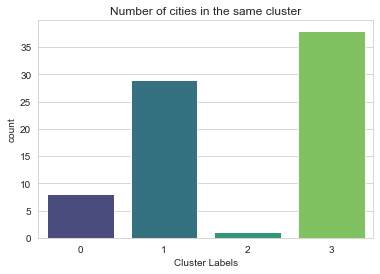

In [18]:
sns.countplot(x = attica_merged['Cluster Labels'], palette='viridis')
plt.title('Number of cities in the same cluster')

Text(0.5, 1.0, '1st most common venue for in each cluster')

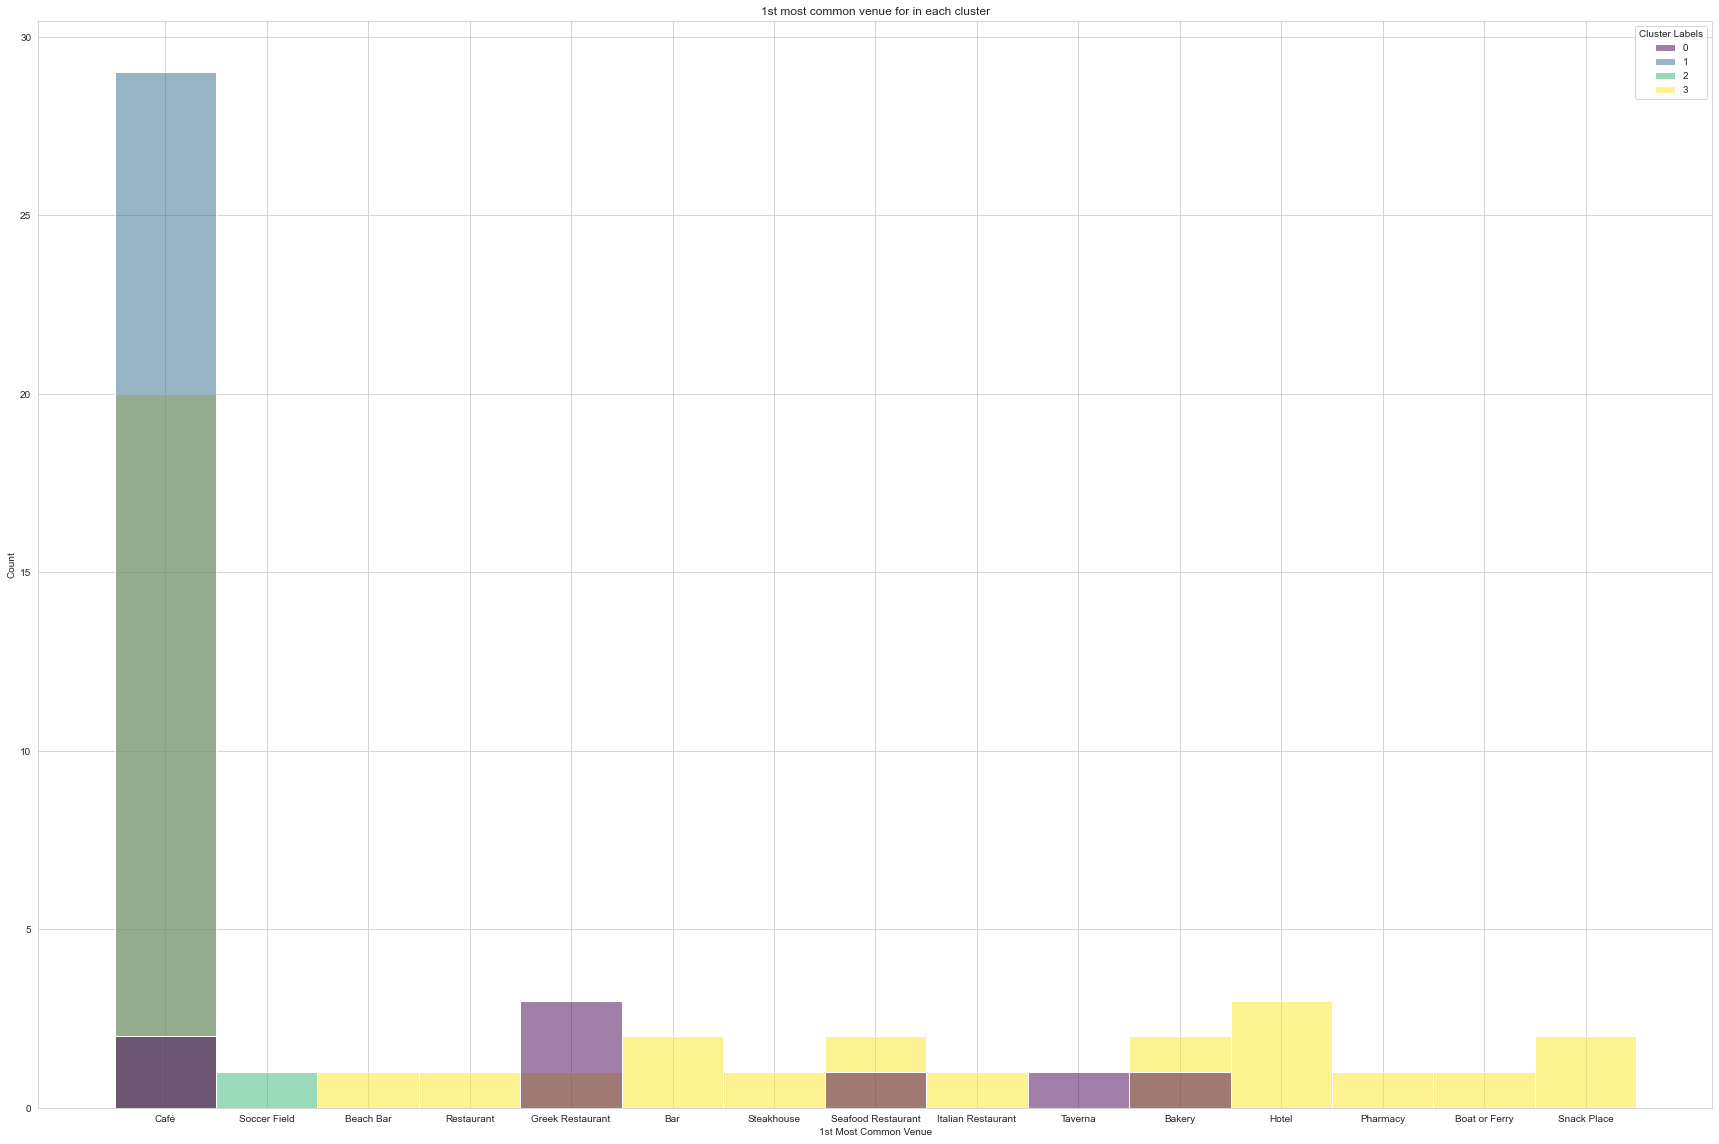

In [22]:
plt.figure(figsize=(30,20))
sns.histplot(x = attica_merged['1st Most Common Venue'],hue= attica_merged['Cluster Labels'], palette='viridis')
plt.title('1st most common venue for in each cluster')

There are a lot of Cafes in Attica

In [23]:
attica_merged[attica_merged['Cluster Labels']==0].drop(['Latitude','Longitude','Cluster Labels'], axis=1)

,City,Region,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Anavyssos,Attica,Greece,Café,Greek Restaurant,Bakery,Kebab Restaurant,Seafood Restaurant,American Restaurant,Pharmacy,Outdoors & Recreation,Ouzeri,Park
16,Argyroupoli,Attica,Greece,Greek Restaurant,Taverna,Waterfall,Restaurant,Food,Hotel,American Restaurant,Park,Other Nightlife,Outdoor Sculpture
45,Kalyvia Thorikou,Attica,Greece,Taverna,Snack Place,Greek Restaurant,Fast Food Restaurant,Soccer Field,Grilled Meat Restaurant,Bakery,Bar,Café,American Restaurant
56,Lykovrysi,Attica,Greece,Bakery,Greek Restaurant,Café,Soccer Field,Snack Place,Hotel,Creperie,Burger Joint,Meze Restaurant,Pharmacy
57,"Magoula, Attica",Attica,Greece,Café,Greek Restaurant,Taverna,Indoor Play Area,Cocktail Bar,Park,Persian Restaurant,Outdoors & Recreation,Ouzeri,Performing Arts Venue
77,"Nikaia, Attica",Attica,Greece,Greek Restaurant,Bakery,Snack Place,Steakhouse,Taverna,Performing Arts Venue,Seafood Restaurant,Park,Health & Beauty Service,Café
81,"Palaia Fokea, Attica",Attica,Greece,Seafood Restaurant,Greek Restaurant,Beach,Taverna,Bakery,Beach Bar,Pool,Italian Restaurant,Eastern European Restaurant,Cafeteria
90,Pikermi,Attica,Greece,Greek Restaurant,Bakery,Grilled Meat Restaurant,Restaurant,Taverna,Café,Steakhouse,Snack Place,Hotel,Breakfast Spot


<AxesSubplot:xlabel='1st Most Common Venue', ylabel='count'>

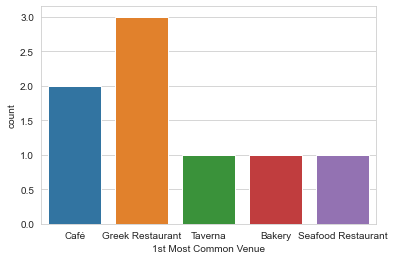

In [26]:
x = attica_merged[attica_merged['Cluster Labels']==0].drop(['Latitude','Longitude','Cluster Labels'], axis=1)
sns.countplot(x = x['1st Most Common Venue'])

In [27]:
attica_merged[attica_merged['Cluster Labels']==1].drop(['Latitude','Longitude','Cluster Labels'], axis=1)

,City,Region,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acharnes,Attica,Greece,Café,Meze Restaurant,Bakery,Cocktail Bar,Taverna,Pizza Place,Creperie,Professional & Other Places,Pool Hall,Pool
14,Anoixi,Attica,Greece,Café,Magirio,Bakery,Taverna,Pharmacy,American Restaurant,Persian Restaurant,Outdoor Sculpture,Outdoors & Recreation,Ouzeri
18,Aspropyrgos,Attica,Greece,Café,Greek Restaurant,Bakery,Taverna,Soccer Field,Kafenio,Bar,American Restaurant,Performing Arts Venue,Outdoor Sculpture
21,Chaidari,Attica,Greece,Café,Greek Restaurant,Meze Restaurant,Fast Food Restaurant,Grilled Meat Restaurant,Snack Place,Pharmacy,Creperie,Bakery,Dance Studio
29,Eleusis,Attica,Greece,Café,Greek Restaurant,Fast Food Restaurant,Meze Restaurant,Snack Place,Burger Joint,Bakery,Hotel,Bar,Hotel Bar
34,Galatsi,Attica,Greece,Café,Greek Restaurant,Snack Place,Park,Bakery,Italian Restaurant,Gaming Cafe,Sandwich Place,Grilled Meat Restaurant,Cretan Restaurant
37,Glyka Nera,Attica,Greece,Café,Snack Place,Bar,Cafeteria,Spa,Cocktail Bar,Bakery,Modern Greek Restaurant,Pizza Place,Park
39,"Ilion, Greece",Attica,Greece,Café,Greek Restaurant,Fast Food Restaurant,Burger Joint,Bar,Meze Restaurant,Performing Arts Venue,Soccer Field,Snack Place,Breakfast Spot
44,Kallithea,Attica,Greece,Café,Greek Restaurant,Meze Restaurant,Bakery,Massage Studio,Kebab Restaurant,Kafenio,Park,Hookah Bar,Burger Joint
46,Kamatero,Attica,Greece,Café,Bakery,Cretan Restaurant,Italian Restaurant,American Restaurant,Pier,Outdoors & Recreation,Ouzeri,Park,Performing Arts Venue


<AxesSubplot:xlabel='1st Most Common Venue', ylabel='count'>

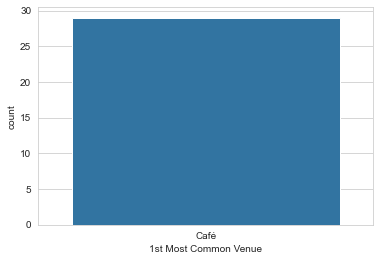

In [28]:
x = attica_merged[attica_merged['Cluster Labels']==1].drop(['Latitude','Longitude','Cluster Labels'], axis=1)
sns.countplot(x = x['1st Most Common Venue'])

In [29]:
attica_merged[attica_merged['Cluster Labels']==2].drop(['Latitude','Longitude','Cluster Labels'], axis=1)

,City,Region,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Agios Ioannis Rentis,Attica,Greece,Soccer Field,Snack Place,Martial Arts School,Theater,Kebab Restaurant,Food Stand,Pizza Place,Outdoor Sculpture,Outdoors & Recreation,Ouzeri


In [63]:
attica_merged[attica_merged['Cluster Labels']==3].drop(['Latitude','Longitude','Cluster Labels'], axis=1)

,City,Region,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Agios Ioannis Rentis,Attica,Greece,Bar,Café,American Restaurant,Salon / Barbershop,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant,New American Restaurant,Nightclub
8,"Agios Stefanos, Attica",Attica,Greece,Coffee Shop,Café,Souvlaki Shop,American Restaurant,Salon / Barbershop,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant,New American Restaurant
9,Aigaleo,Attica,Greece,Café,Meze Restaurant,Bar,Coffee Shop,Souvlaki Shop,Kebab Restaurant,Creperie,Tsipouro Restaurant,Sports Bar,Seafood Restaurant
11,"Marousi, Attica",Attica,Greece,Café,Bar,Coffee Shop,Cocktail Bar,Souvlaki Shop,German Restaurant,Grilled Meat Restaurant,Salon / Barbershop,Creperie,Gaming Cafe
12,Anavyssos,Attica,Greece,Café,Kebab Restaurant,Greek Restaurant,Souvlaki Shop,Seafood Restaurant,Tsipouro Restaurant,Turkish Restaurant,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Vouliagmeni,Attica,Greece,Café,Souvlaki Shop,Restaurant,Seafood Restaurant,Italian Restaurant,Sushi Restaurant,Grilled Meat Restaurant,Taverna,Greek Restaurant,Creperie
108,Vrilissia,Attica,Greece,Tsipouro Restaurant,Café,Coffee Shop,Souvlaki Shop,American Restaurant,Sake Bar,Mexican Restaurant,Meze Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant
109,Vyronas,Attica,Greece,Café,Greek Restaurant,Mediterranean Restaurant,Bar,Beer Bar,Coffee Shop,Salon / Barbershop,Meze Restaurant,Middle Eastern Restaurant,Modern Greek Restaurant
110,Ymittos,Attica,Greece,Café,Greek Restaurant,Meze Restaurant,Bar,Taverna,Grilled Meat Restaurant,Coffee Shop,Souvlaki Shop,Ouzeri,Sake Bar


<AxesSubplot:xlabel='1st Most Common Venue', ylabel='count'>

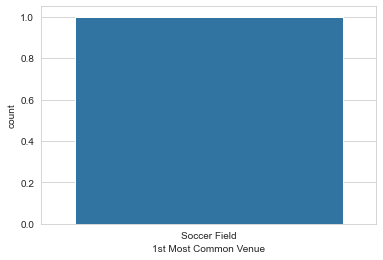

In [30]:
x = attica_merged[attica_merged['Cluster Labels']==2].drop(['Latitude','Longitude','Cluster Labels'], axis=1)
sns.countplot(x = x['1st Most Common Venue'])

In [31]:
attica_merged[attica_merged['Cluster Labels']==3].drop(['Latitude','Longitude','Cluster Labels'], axis=1)

,City,Region,Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Agios Stefanos, Attica",Attica,Greece,Café,Snack Place,Bank,Pharmacy,Seafood Restaurant,Creperie,Pizza Place,Dance Studio,Magirio,Restaurant
9,Aigaleo,Attica,Greece,Café,Meze Restaurant,Bar,Greek Restaurant,Snack Place,Bakery,Cocktail Bar,Theater,Kebab Restaurant,Burger Joint
10,Alimos,Attica,Greece,Beach Bar,Hotel,Bakery,Beach,Park,Greek Restaurant,Meze Restaurant,Spa,Dance Studio,Grilled Meat Restaurant
11,"Marousi, Attica",Attica,Greece,Café,Bar,Cocktail Bar,Office,Bakery,Theater,Music Venue,Dance Studio,Multiplex,Pizza Place
13,Ano Liosia,Attica,Greece,Restaurant,Café,Pizza Place,Bar,Burger Joint,Persian Restaurant,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Ouzeri
17,"Artemida, Attica",Attica,Greece,Café,Seafood Restaurant,Snack Place,Grilled Meat Restaurant,Fish Taverna,Creperie,Meze Restaurant,Mexican Restaurant,Tsipouro Restaurant,Surf Spot
19,Athens,Attica,Greece,Bar,Café,Theater,Falafel Restaurant,Cocktail Bar,Magirio,Kafenio,Vegetarian / Vegan Restaurant,Hotel,Greek Restaurant
22,Chalandri,Attica,Greece,Café,Bar,Greek Restaurant,Restaurant,Cocktail Bar,Pizza Place,Italian Restaurant,Bakery,Seafood Restaurant,Fast Food Restaurant
23,Cholargos,Attica,Greece,Café,Italian Restaurant,Cocktail Bar,Bakery,Burger Joint,Snack Place,Park,Dance Studio,Sushi Restaurant,Greek Restaurant
24,"Dafni, Attica",Attica,Greece,Café,Bar,Greek Restaurant,Bakery,Meze Restaurant,Restaurant,Snack Place,Multiplex,Taverna,Sandwich Place


<AxesSubplot:xlabel='1st Most Common Venue', ylabel='count'>

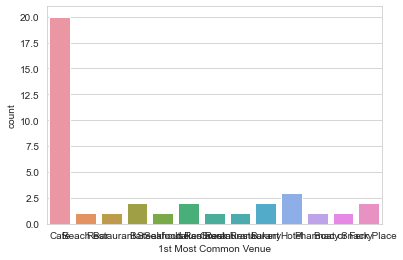

In [32]:
x = attica_merged[attica_merged['Cluster Labels']==3].drop(['Latitude','Longitude','Cluster Labels'], axis=1)
sns.countplot(x = x['1st Most Common Venue'])